# Simulating a water drop in molecular dynamics

#### Tan Beng Hau, Cavitation Lab

In this notebook I create a box of water molecules and melt it to room temperature. The exact instructions are really dependent on which molecular dynamics (MD) solver is used. Here I use Lammps and a companion package, Moltemplate, which greatly simplifies the setup of the simulation. 

I am not an MD specialist, so I foresee that there might be a mistake or oversight somewhere. If you plan to use this notebook as a reference for anything serious you should preferably defer to the advice of someone who is knowledgeable about MD. 

## Creating a box of water molecules

I used the `moltemplate` package to produce the input file (`system.in`) for the simulation as well as the data file (`system.data`), which contains essentially the molecule coordinates, bond information and so forth. 

**The water box file.** The `moltemplate` philosophy is modular. In the case of a water box, I simulate it with the SPC/E force field, using an `spce.lt` template file which can be found on the `moltemplate` website. This template file essentially defines what a water molecule is (atoms, force field parameters, bonds and so forth). I then create a second file, `water_box.lt`. In this file, I tell `moltemplate` to create 10 copies of the water molecule in the $x,y,z$ directions, and then shift the whole box by 17.25 A. The separation of 3.45 A was chosen so that the water box has a density of approximately 1 kg/m$^3$ at the outset. 

```
# water_box.lt
wat = new SPCE [10].move(0, 0, 3.45)
      	       [10].move(0, 3.45, 0)
      	       [10].move(3.45, 0, 0)

wat[*][*][*].move(17.25, 17.25, 17.25)
```

**The system file. **Lastly, we need a third file, `system.lt`, which references the `water_box.lt` file and specifies the boundaries. This seems a bit overkill but it is useful if we want to make a more complicated simulation by introducing an obstacle, boundaries, etc. We would then call these other molecules in `system.lt`. Here is the system template file.

```
# system.lt
import "water_box.lt"

write_once("Data Boundary") {
    0 69 xlo xhi
    0 69 ylo yhi
    0 69 zlo zhi
}
```

**Executing moltemplate**. I then generate the Lammps input files with `moltemplate.sh system.lt` in the command line.

The assembled water box looks like this. The simulation domain is visualised in VMD using the topotools plugin (in the VMD command line run `topo readlammpsdata system.data`). 

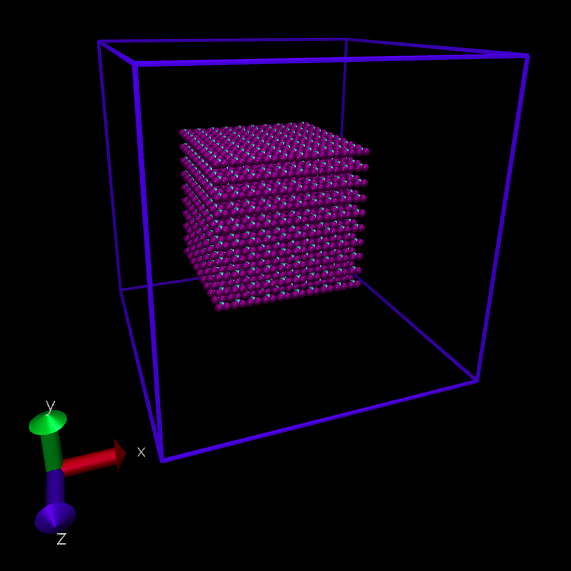

In [24]:
from IPython.display import Image
Image(filename='images/water_initial.png')

## Simulation input script 

Moltemplate generates four files for the simulation, which are

* `system.in.init` and `system.in.settings` - defines force field parameters and other settings
* `system.data` - the coordinates of the water molecules
* `system.in` - the main command input file into Lammps

In particular, the `system.in` file reads:

```


# ----------------- Init Section -----------------

include "system.in.init"


# ----------------- Atom Definition Section -----------------

read_data "system.data"

# ----------------- Settings Section -----------------

include "system.in.settings"


# ----------------- Run Section -----------------
# Unfix the shake, then minimize. 
unfix fShakeSPCE
minimize 1.0e-5 1.0e-7 1000 10000
fix fShakeSPCE spce shake 0.0001 10 100 b 1 a 1

# NVT equilibration
timestep 1.0
fix   fxnvt all nvt temp 300.0 300.0 500.0 tchain 1

# Set up variables
variable	VOL equal vol
variable	TIME equal time
variable	TEMP equal temp
variable	STEP equal step

# Output to screen, file output, etc.
thermo_style	custom time step temp pe etotal vol press
thermo		1000
dump		dumpNVT all atom 100 water-nvt.lammpstrj
fix		thermoNVT all print 500 "${TIME} ${STEP} ${TEMP} ${VOL}" file water_nvt_thermo.txt

run   		100000
write_data	water_nvt.data
```

Essentially, this file:

1. **Reads in the force field parameters** and the **molecular coordinates** from the other `system.in.init` and `system.in.settings` files.
2. Sets up **energy minimisation**, which shifts the molecules around a little bit to ensure that the system doesn't blow up. Note that the SPC/E data file I used from the Moltemplate site imposes a `fix/shake` on the water molecules which ensures that the specified bond lengths and angles are reset during the full MD run. The SHAKE algorithm is not compatible with the minimisation so here we turn it off, perform the minimisation, and then turn it on again. 
3. Equilibrates the system in the **NVT ensemble** at a temperature of 300 K and a timestep of 1.0 fs. 
4. Specifies how to generate **output**. Here we want to write the output to external files. One is a **dump file** which contains the coordinates of all the molcules every 100 timesteps. The other records the **thermodynamic data** such as temperature and volume, this time every 500 timesteps. 
5. Instructs the NVT simulation to be carried out for **100 ps**. 

## NVT equilibration

After the simulation, the water box becomes a water drop. We will also see that the temperature needs some time to settle to the 300 K constraint that we have imposed. 

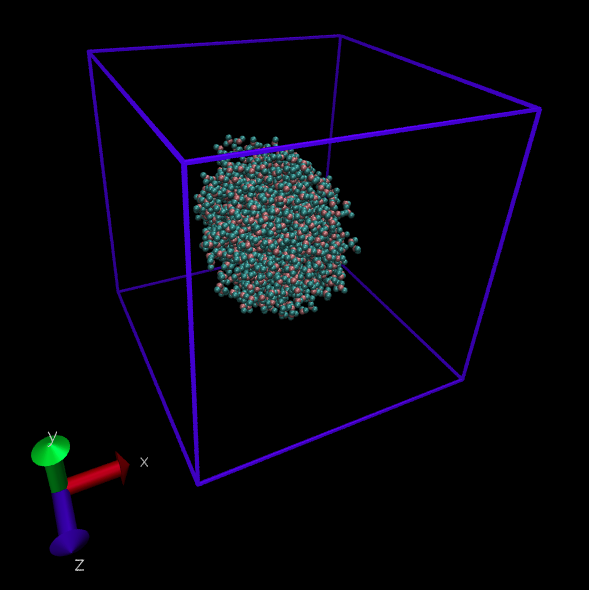

In [27]:
from IPython.display import Image
Image(filename='images/water_nvt.png')

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # for those with HD screens

In [2]:
data = pd.read_csv('water_nvt_thermo.txt', sep=' ')

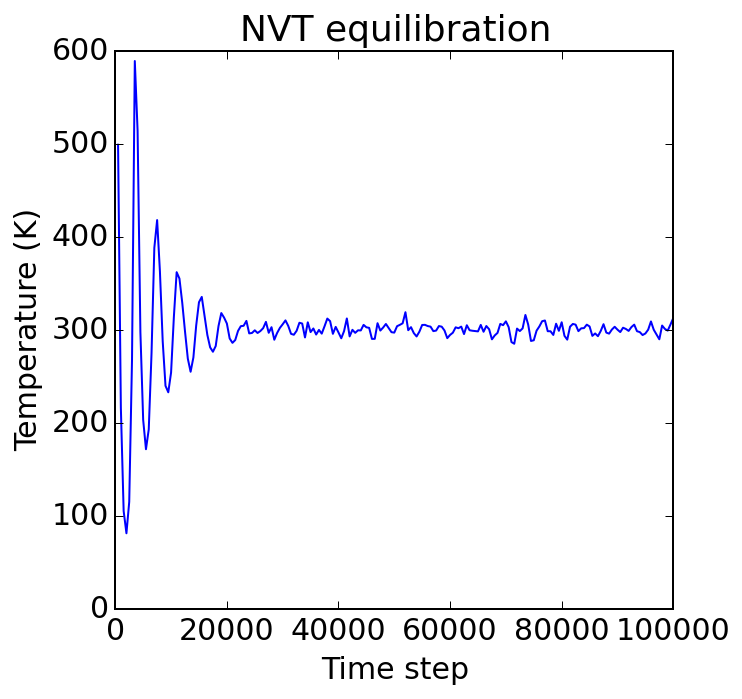

In [3]:
plt.figure(figsize=(5,5))
plt.rcParams['font.size'] = 15
plt.plot(data['step'], data['temp'])
plt.xlabel('Time step')
plt.ylabel('Temperature (K)')
plt.title('NVT equilibration')

## NPT equilibration

Next, I equilibrated the system at $T=$ 300 K while constraining the system pressure to be at 1 atmosphere. This run is also for 100 ps, and I collect thermodynamic data for the temperature, pressure and so forth every 100 fs. 

There is substantial fluctuation in the pressure, and moreover, pressure equilibration typically takes a much longer time than the temperature equilibration. To check the mean value of the pressure I take a rolling mean over $10\times 100 = 10^3$ fs. It averages out at close to the isobaric constraint of 1 atmosphere, more or less.  

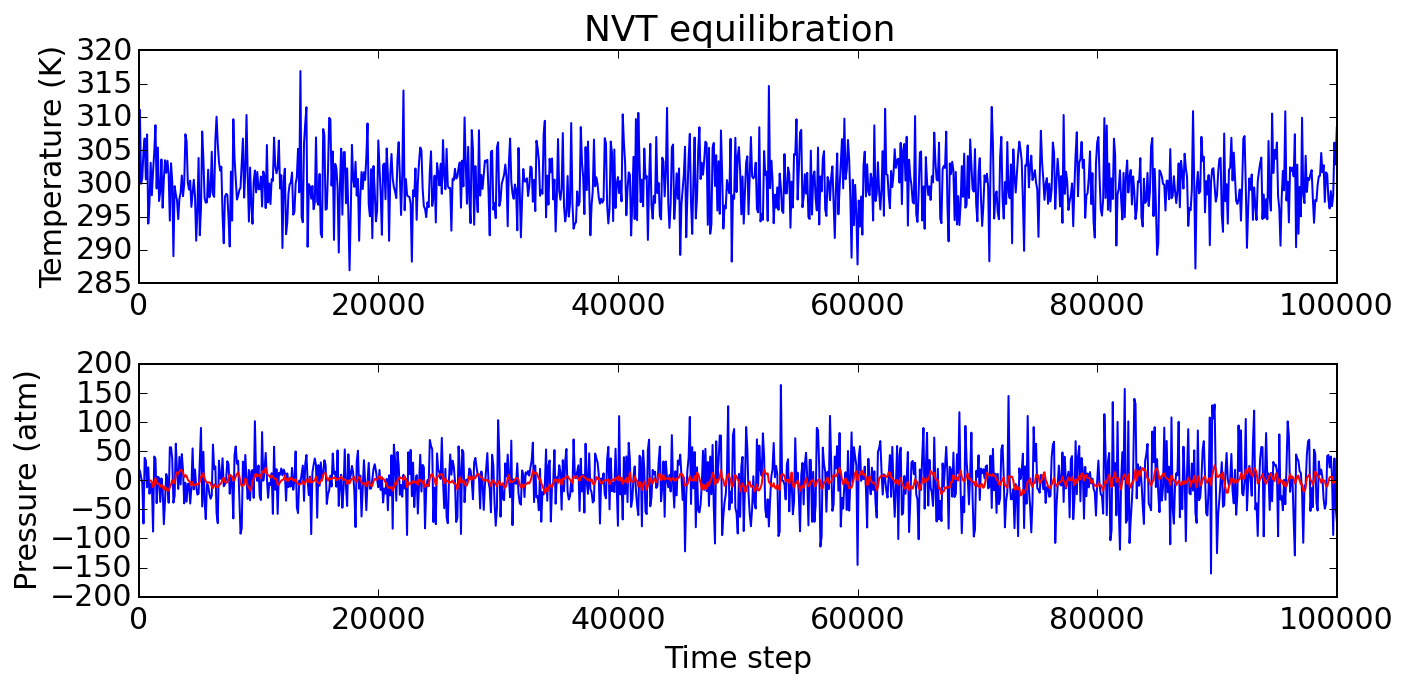

In [5]:
data_npt = pd.read_csv('water_nvtnpt_thermo.txt', sep=' ')
press_roll = pd.rolling_mean(data_npt['press'],10)
plt.figure(figsize=(10,5))
plt.rcParams['font.size'] = 15
plt.subplot(211)
plt.plot(data_npt['step'], data_npt['temp'])
# plt.xlabel('Time step')
plt.ylabel('Temperature (K)')
plt.title('NVT equilibration')
plt.subplot(212)
plt.plot(data_npt['step'], data_npt['press'])
plt.plot(data_npt['step'], press_roll, 'r')
plt.xlabel('Time step')
plt.ylabel('Pressure (atm)')
plt.tight_layout()

In [6]:
press_roll.mean()

-0.61139997353229791